## Formatting the data
The data available is not perfect. Some articles have missing information. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

The necessary features are: __Domain, Body, Header__ and __Byline__. URI is nice to have, but not necessary.

Author: lkt259@alumni.ku.dk

In [1]:
import numpy as np
import pandas as pd
import os, re
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
import random
from difflib import SequenceMatcher
plt.style.use('seaborn')

scrape = True

In [2]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data_0.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,842325,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var ov...,Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk,2002-09-17T00:00:00,https://politiken.dk/forbrugogliv/art6088327/Utilfreds-passager-%C2%BBPr%C3%B8v-selv-en-tur-klokken-7.30-en-hverdagsmorgen%C2%AB,Annemette Grundtvig,-346867430
1,842324,politiken.dk,"Klimamonitor Byrummonitor Skolemonitor Sundhedsmonitor Kulturmonitor Følg os Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« For to år siden fik forfatter ...","Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« - politiken.dk",2013-01-18T00:00:00,https://politiken.dk/forbrugogliv/art6287464/%C2%BBOfte-st%C3%A5r-jeg-og-mangler-en-ting-og-bliver-irriteret-p%C3%A5-mig-selv-over-at-jeg-har-smidt-den-ud%C2%AB,Annemette Grundtvig,-1346564151
2,842323,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . Køb abonnement Den familie...,Digitalt forældreskab: Hvilken type er du som Facebook-forælder? - politiken.dk,2006-05-17T00:00:00,https://politiken.dk/forbrugogliv/art5934818/Hvilken-type-er-du-som-Facebook-for%C3%A6lder,Annemette Grundtvig,1473032676


### Removing duplicates and empty bodies
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [3]:
def print_stats():
    print(f"{data.shape[0]} entries.")
    print(f"{data.Byline.unique().shape[0]} authors.")
    print(f"{data.Domain.unique().shape[0]} domains.")

def same_uri(uri):
    return data[data['Uri']==uri]

def remove_duplicates(data):
    print("With duplicates:", data.shape)
    data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
    empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
    data = data[data['Body'] != '']
    empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.
    duplicate_bodies = data[data.duplicated(subset=["Body"])]
    data = data.drop_duplicates(subset=['Body']) #Can remove all duplicate bodies here, after None-bodies are removed.
    data = data.drop_duplicates(subset=["Uri"]) #Remove entries with same URI
    
    print("Without duplicates:", data.shape)
    return data, empty_bodies, duplicate_bodies

data, _, _ = remove_duplicates(data)

With duplicates: (10000, 8)
Without duplicates: (9070, 8)


### Removing unknown authors, headers and domains

In [4]:
def remove_missing_feats(data):
    no_author, no_header, no_domain = None, None, None
    
    if data['Byline'].isnull().values.any(): #Missing authors
        no_author = data[data['Byline'].isnull()]
        data = data.dropna(subset=['Byline'])
        print("Without unknown authors:", data.shape)

    if data['Header'].isnull().values.any():
        no_header = data[data['Header'].isnull()]
        data = data.dropna(subset=['Header'])
        print("Without unknown title:", data.shape)
    
    data = data[data.Header != '']

    if data['Domain'].isnull().values.any():
        no_domain = data[data['Domain'].isnull()]
        data = data.dropna(subset=['Domain'])
        print("Without unknown domains:", data.shape)
        
    return data, no_author, no_header, no_domain

data, _, _, _ = remove_missing_feats(data)

### Applying to all data files.
After investigating the data, let's apply the changes to the files. No need in formatting multiple times. Also, let's see how the distributions are when collecting all data.

In [5]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/'+file)])

print_stats()

  0%|          | 0/80 [00:00<?, ?it/s]

808066 entries.
66994 authors.
268 domains.


In [6]:
#Used for plotting later...
body_lengths = data['Body'].str.len()
y2, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x2 = 0.5*(bin_edges[1:] + bin_edges[:-1])

#### Remove duplicated and missing data
Some data did not meet the requirements. How much data do we have left?

In [7]:
data, empty_bodies, duplicate_bodies = remove_duplicates(data)
data, no_author, no_header, no_domain = remove_missing_feats(data)

#Removing bad authors. Baaad author, shame on you!
bad_byline = data[data['Byline']==data['Uri']]
data = data[data['Byline']!=data['Uri']]
print("With bad authors removed:", data.shape)
print_stats()

With duplicates: (808066, 8)
Without duplicates: (431531, 8)
Without unknown authors: (398856, 8)
With bad authors removed: (348751, 8)
348751 entries.
7849 authors.
205 domains.


In [31]:
#Titel-ize Authors!
data.Byline = data.Byline.str.title()
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:-5],"\n...")

Unique authors:  1864
Anne Sophia Hermansen    13558
Karim Pedersen            7157
Thomas Treo               6173
Mads Elkær                4898
Benny Baagø               4250
                         ...  
Morten Østergaard            2
Bjørn Lomborg                2
Hans K. Sønderby             2
Bernhard Hagen               2
Knud N. Mathiesen            2
Name: Byline, Length: 1859, dtype: int64 
...


In [30]:
print(len(empty_bodies), "empty bodies")
print(len(no_author), "without author")
#print(len(no_header), "without header")
#print(len(no_domain), "without domain")
print(len(bad_byline), "malformed authors")

448 empty bodies
32675 without author
28789 malformed authors


### Author cleanup! Removing multiple authors.
Some entries have multiple auhthors. How big a problem does this cause?

In [10]:
authors = list(data['Byline'])[1:] #First entry is empty.
multiple_authors_candidates = []
for author in authors:
    if any(x in author for x in ['|',',']):
        multiple_authors_candidates.append(author)

print("Entries with multiple authors (and titles, cities):" ,len(multiple_authors_candidates))
print(f"Unique combinations of authors: {len(set(multiple_authors_candidates))}")

#multiple_authors = [re.split('\||,',x) for x in multiple_authors]

Entries with multiple authors (and titles, cities): 11275
Unique combinations of authors: 4749


**Now! Let us remove entries with multiple authors.**

Some authors are actually not multiple authors, but cities and titles. These entries will be kept, but stripped from everything except the name. We don't want multiple authors, as this project focuses on single authors.

In [11]:
#Read txt file with words that should not be masked.
with open('data/additional/author_filter.txt', encoding='utf-8') as f:
    lst = f.read()
    lst = lst.split('\n')

author_filter = lst

print(f"{len(set([x for x in multiple_authors_candidates if '|' in x]))} authors removed by '|-rule'")
bar_rule = [x for x in multiple_authors_candidates if '|' in x]
multiple_authors_candidates = [x for x in multiple_authors_candidates if '|' not in x] #Remove entries with | in them.

new_authors_candidates = []
author_names_without_city = [] #Save the new, stripped name and the old one, to edit data fterwards.

for candidate in multiple_authors_candidates:
    names = candidate.split(',') #Split by , to separate authors or cities    
    
    append = True
    
    #Loop through names
    for name in names:
        name = name.strip()
        if len(name.split())>1: #Name is not two or more names.
            if any(ele in name for ele in author_filter): #Do not append if name found in filter.
                append = False
        else:
            append = False
    
    if append:
        new_authors_candidates.append(candidate)
    else:
        #Append to names list without cities. 
        if any(ele in names[0] for ele in author_filter): #If first name appears in filter, use second name.
            author_names_without_city.append((names[1], candidate))
        else:
            author_names_without_city.append((names[0], candidate))
            
print(f"{len(set(new_authors_candidates))} author combinations removed by filter.")
print(f"Kept {len(set([x[0] for x in author_names_without_city]))} authors (Not sure if they are new authors yet).")

already_there_hon = 0
uniques = data['Byline'].unique()
for i in set([x[0] for x in author_names_without_city]):
    if i in uniques:
        already_there_hon += 1
        
print(f"{already_there_hon} authors already present in data by themselves.")

2897 authors removed by '|-rule'
1457 author combinations removed by filter.
Kept 220 authors (Not sure if they are new authors yet).
142 authors already present in data by themselves.


In [12]:
#Drop multiple authors from data.
data = data[data['Byline'].isin(new_authors_candidates) == False]
data = data[data['Byline'].isin(bar_rule) == False]

#Convert wrong names to right names in data.
#Badly optimised...
print("Converting names...")
for entry in tqdm(author_names_without_city):
    name = entry[0]
    wrong_name = entry[1]
    
    data.loc[data["Byline"] == wrong_name, "Byline"] = name
print("Names are converted! That was slow.")

Converting names...


  0%|          | 0/1477 [00:00<?, ?it/s]

Names are converted! That was slow.


In [13]:
## Remove authors: Redaktionen and Ritzau /Nyheder
data = data[data.Byline.isin(['Redaktionen', 'Ritzau /Nyheder']) == False]

In [14]:
print_stats()

336823 entries.
3176 authors.
205 domains.


## Removing Unique Entries
We don't want unique author or domain names. We need **at least** two entries for each.

In [15]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [16]:
#Find which author names that can be salvaged. (Are they calpitalized?)
d = data['Byline'].value_counts()
unique_authors = d[d<2].keys()
common_authors = d[d>2].keys()

for author in unique_authors:
    author = author.strip()
    if author.istitle():
        continue
    if author.isupper() or author.islower():
        if author.title() in common_authors:
            data.loc[data["Byline"] == author, "Byline"] = author.title()

#Remove any entries with single-occuring authors.
data = data[data['Byline'].isin(unique_authors) == False]

In [17]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [18]:
print_stats()

335607 entries.
1932 authors.
193 domains.


### Additional cleanup
Removing duplicated headers and foreign domains.

In [19]:
h = data['Header'].value_counts()
data = data[data['Header'].isin(h[h>20][1:].keys())==False]

**Remove foreign domains** - We don't want German texts!

In [20]:
domains = ('.dk', 'nordicwomeninfilm.com', 'linkedin.com', 'betxpert.com', 'kommunikation.com', 'radar.com', 'ea.com', 'ue.com','ce.com', '.international', 'e.nu')
print(data[data['Domain'].str.endswith(domains)==False].shape[0], "entries with foreign domains.")
data = data[data['Domain'].str.endswith(domains)]
print_stats()

24924 entries with foreign domains.
307977 entries.
1893 authors.
162 domains.


__Duplicate domains:__ computerworld.dk has 3 domains of different formats. Unify them.

In [21]:
data.loc[data.Domain.isin(["Computerworld.dk", "www.computerworld.dk"]), 'Domain'] = 'computerworld.dk'

## Scrape 31k articles
Some articles have the same header, same body. The domains are limited to bt.dk and berlingske.dk - making a scraper is not too hard.

In [22]:
remove = []
import traceback
if scrape:
    try:
        data = data.reset_index()
    except:
        pass
    import scraper
    
    treo = data[data['Byline']=='Thomas Treo']
    anne = data[data['Byline']=='Anne Sophia Hermansen']
    corrupt_data = data[data['Header']=='Din profil er oprettet']
    corrupt_data = pd.concat((corrupt_data, treo, anne))
    
    errors = []
    _404s = []
    
    i = 0
    o = corrupt_data.shape[0]

    for idx, article in tqdm(corrupt_data.iterrows()):
        url = article.Uri

        try:
            header, body, author = scraper.get_content(url)

        except Exception as e:
            i += 1
            errors.append((url, e))
            remove.append(article.Id)
            print(traceback.format_exc())
            continue
    
        if type(author) == list:
            errors.append((url, f"MULTIPLE AUTHORS:{author}"))
            remove.append(article.Id)
            continue
            
        if author != '404':
            data.iloc[idx, data.columns.get_loc('Header')] = header
        else:
            _404s.append(url)
            continue
            
        if body != '404':
            data.iloc[idx, data.columns.get_loc('Body')] = body
            
        if author != '404':
            data.iloc[idx, data.columns.get_loc('Byline')] = author

        print(header, f"({i}/{o})")
        i += 1
        
data = data[data.Id.isin(remove)==False]
data.to_json(r'data/additional/scraped_data_raw.json')

0it [00:00, ?it/s]

Non-names: ['Ansvarshavende chefredaktør']
Kulturen er pist borte (0/31021)
Non-names: ['Ansvarshavende chefredaktør']
Vi kalkulerer hver dag med menneskers død (1/31021)
Non-names: ['Ansvarshavende chefredaktør']
Gud nåde og trøste os, hvis Bernie Sanders bliver præsident (2/31021)
Non-names: ['Ansvarshavende chefredaktør']
Borgerlige burde stille sig på borgernes side mod regeringens forlorne folkelighed (3/31021)
Non-names: ['Kulturkommentator']
Vi forstår nu, hvorfor Katrine Marie Guldager er enestående. Selv når hun skriver for langt (4/31021)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Det kan vi lære af den mest dysfunktionelle sæson af »Gift ved første blik« nogensinde (5/31021)
Non-names: ['Kulturkommentator']
Portræt af et røvhul: Ny Netflix-dokumentar genoptager sagen om den hvide IMF-konge og den sorte stuepige (6/31021)
Non-names: ['Kulturkommentator']
Anne Sophia Hermansen: Latterligt, tænkte jeg, da jeg så en mand skrive, at han ikke ville ansætte attraktive 

KeyboardInterrupt: 

In [25]:
data.Byline.value_counts()

Anne Sophia Hermansen       13558
Karim Pedersen               7157
Mads Elkær                   4893
Benny Baagø                  4250
Thomas treo                  4215
                            ...  
Jens Peter  Christensen         2
Iben og Niels Ahlberg           2
Christian Møller-Nielsen        2
Søren Sørensen                  2
Betty Frank Simonsen            2
Name: Byline, Length: 1893, dtype: int64

In [ ]:
data = data[data.Id.isin(remove)==False]
data = data.reset_index()
data.to_json(r'data/additional/scraped_data_raw.json')

### Define junk text

In [ ]:
#This function will identify phrases that are repeated throughout the domains. 
#However, it will have multiple duplicate matches, making the conversion slow... Oh well...
def get_junk_by_domain(domain, verbose=False):
    bodies = data[data.Domain==domain].Body.to_list()
    junk = {}
    if verbose:
        print("Started on", domain)
    for i in range(len(bodies)//4):
        randomindex = None

        while True:
            randomindex = random.randint(0,len(bodies)-1)
            if randomindex != i:
                break

        string1 = bodies[i]
        string2 = bodies[randomindex]

        #match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))

        matches = SequenceMatcher(None, string1, string2).get_matching_blocks()
                
        for match in matches[:-1]:
            if match.size > 20:
                matchstr = string1[match.a: match.a + match.size] 
                if matchstr not in junk:
                    junk[matchstr] = 1
                else:
                    junk[matchstr] += 1
    
    if verbose:
        print(f"Found {len(junk)} sentences to remove in {domain}...")
    
    keys = list(junk.keys())
    if verbose:
        print(keys)
    junk_list = []
                
    for key in keys:
        if junk[key] > 2:
            junk_list.append(key)
    
    if verbose:
        print(f"Narrowed that down to {len(junk_list)} junk sentences.")
    
    return junk_list

In [ ]:
domain_junk = {}
for domain in tqdm(data.Domain.unique()):
    domain_junk[domain] = get_junk_by_domain(domain)

### Remove author and newspaper names
We don't want author and newspaper names in bodies and headlines. Let's DEMOLISH them. Also remove URL's and HTML tags and junk text.

In [ ]:
#data = data.reset_index()
placeholder_author = '{FORFATTER}'
placeholder_domain = '{AVIS}'

num_new_headers = 0
num_new_bodies = 0
junk_removed = 0

#Remove URL and HTML junk from body
def strip_tags(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    return text

def strip_junk(text, junk):
    reg = re.compile('|'.join(map(re.escape, junk)), re.IGNORECASE)
    return reg.sub("", text)

for idx, article in tqdm(data.iterrows()):
    domain_no_dot = article.Domain.split('.')[0]

    new_header = article.Header
    new_body = article.Body

    reg_author = re.compile(re.escape(article.Byline), re.IGNORECASE)
    reg_domain = re.compile(re.escape(domain_no_dot), re.IGNORECASE) 

    #Change body
    if reg_author.search(article.Body) or reg_domain.search(article.Body):
        num_new_bodies += 1

        new_body = reg_author.sub(placeholder_author, article.Body)
        new_body = reg_domain.sub(placeholder_domain, article.Body)
    
    if domain_junk[article.Domain]:
        new_body = strip_junk(new_body, domain_junk[article.Domain])
        junk_removed += 1
    
    data.iloc[idx, data.columns.get_loc('Body')] = strip_tags(new_body)
    
    #Change header
    if reg_author.search(article.Header) or reg_domain.search(article.Header):
        num_new_headers += 1

        new_header = reg_author.sub(placeholder_author, article.Header)
        new_header = reg_domain.sub(placeholder_domain, article.Header)

    data.iloc[idx, data.columns.get_loc('Header')] = new_header

print(f"Altered {num_new_headers} headers.")
print(f"And {num_new_bodies} bodies.")
print(f"And {junk_removed} pieces of junk removed.")

## Save the formatted data as a new JSON
Very important, we do not want to wait for the scraper a second time...

In [ ]:
n = 10000
for g, df in data.groupby(np.arange(len(data)) // n):
    df.to_json(r'data/additional/scraped/data_%s.json'%g)

# Insights in data

### Body lengths
Let's see the distribution of the body lengths.

In [ ]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters\nNot true"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges), label="Preprocessed Data")
plt.step(x2+30, y2*0.41, 'k', alpha=0.8, label="Before Preprocessing")
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
plt.legend(fontsize=14);
#plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
#plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

### Author contributions
How many articles have the authors written?

In [ ]:
counts = list(data['Byline'].value_counts())

# plt.yscale('symlog')
# plt.xlim(-100,4000)

y, bin_edges = np.histogram(counts, bins=200)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))

plt.yscale('symlog')
plt.title("Histogram Over Number of Articles per Author", fontsize=18)
plt.xlabel("Number of articles", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)

 desc = "Outlier: Anne Sophia Hermansen\n13535 articles written."
# plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
# plt.plot([40000,53000], [120,1], '--', c='red', alpha=.6)

### Author body length
Do authors have certain body lengths? In articles, not their actual bodies. Let us make a plot to see if there is a correlation between article count and body length. But first, we need to find the average body length per author. 

In [ ]:
df = pd.DataFrame(columns=['body_length', 'author'])
df['body_length'] = body_lengths
df['author'] = data['Byline']
df['author'].replace('', np.nan, inplace=True)
df = df.dropna()
avg_body_lengths = list(df.groupby(['author']).mean()['body_length'])

In [ ]:
plt.hist(avg_body_lengths, bins=200);
plt.title("Histogram Over Average Article Length per Author", fontsize=16)
plt.xlabel("Average length", fontsize=14)
plt.ylabel("Number of authors", fontsize=14)

In [ ]:
df2 = pd.DataFrame(index=data['Byline'].unique(),columns=['avg_len', 'article_count'])
avg_body_length_series = df.groupby(['author']).mean()['body_length']
article_count_series = data['Byline'].value_counts()

for i in data['Byline'].unique():
    if i == '':
        continue
    
    avg_len = avg_body_length_series[i]
    article_count = article_count_series[i]
    df2.loc[i] = [avg_len, article_count]

df2.head(5)

**Correlation between average length and article count**

Make a dataframe with author, average article length, article count

In [ ]:
x = df2.avg_len
y = df2.article_count
plt.scatter(x[y<2000], y[y<2000], marker='.')
plt.ylabel("Article count")
plt.xlabel("Article length")

x = x.to_numpy(dtype=float)
y = y.to_numpy(dtype=float)
x = np.nan_to_num(x)
y = np.nan_to_num(y)

corr, sig = pearsonr(x,y)
print("Pearsin correlation:", corr)

plt.title("No Linear Correlation Between Article Length and Article Count", fontsize=15);

In [ ]:
data.Byline.str.len().median()

# TESTING

In [ ]:
treo = data[data['Byline']=='Thomas Treo']
anne = data[data['Byline']=='Anne Sophia Hermansen']
corrupt_data = data[data['Header']=='Din profil er oprettet']
corrupt_data = pd.concat((corrupt_data, treo, anne))
corrupt_data.shape

In [120]:
dates = list(data.PublicationDate.str[:4])
int_dates = []
old_af = []
future = []
for i in dates:
    try:
        inti = int(i)
    except:
        continue
    
    if inti < 1995:
        old_af.append(inti)
        continue
    if inti > 2022:
        future.append(inti)
        continue
    int_dates.append(inti)

print(len(old_af), "articles from before 1995")
print(len(future), "articles from the future")

9476 articles from before 1995
34902 articles from the future


c:\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

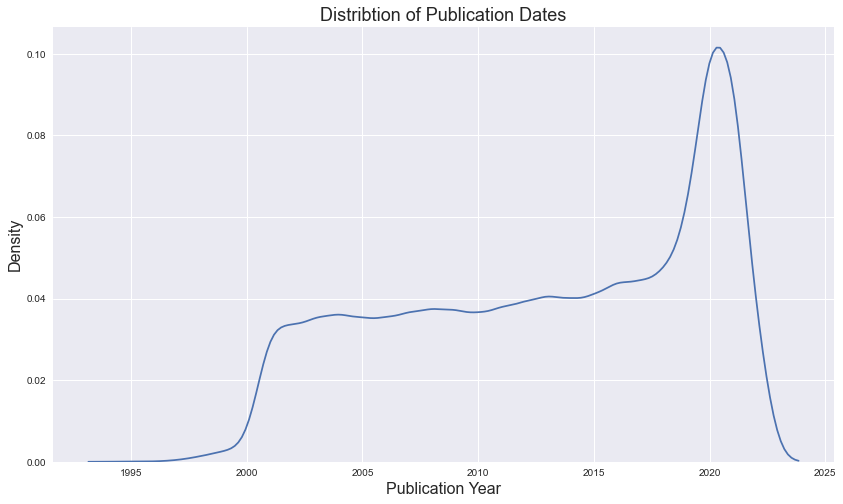

In [121]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(14,8))
sns.distplot(int_dates, hist=False)
plt.title("Distribtion of Publication Dates", fontsize=18)
plt.xlabel("Publication Year", fontsize=16)
plt.ylabel("Density", fontsize=16)

In [115]:
data = pd.read_json('data/additional/preprocessed_data.json')

In [137]:
np.median(future)

2026.0